##Chapter 5 - Spam Detection of Chicago Yelp Reviews
###Part 2: GCN, GAT, and GATv2 Models

This code serves to demonstrate and compare two Graph Attention Network (GAT) architectures in PyG for the task of spam detection using the YelpChi dataset, which contains reviews of restaurants and hotels in Chicago.

This notebook is the second part of an analysis that did EDA on the node features of this dataset and conducted baselines models using logistic regression, XGBoost, and an MLP. This notebook uses GCN as an additional baseline model.

The procedure can be broken down into the following steps:

1. **Data Preparation**: The code begins by loading and preprocessing the YelpChi dataset, including extracting features, labels, and the graph structure. It also splits the data into training and testing sets, ensuring that it is stratified to maintain class balance.

2. **Graph Analysis**: The code conducts an analysis of the graph structure derived from the dataset, including calculating metrics such as the number of nodes, edges, density, and identifying connected components. It also explores properties like degree distribution, centrality, and cycle detection.

3. **Model Training (GCN)**: The code trains a Graph Convolutional Network (GCN) model for spam detection on the preprocessed data. It uses binary cross-entropy loss and tracks metrics like loss and Area Under the Receiver Operating Characteristic Curve (AUC) during training. It also includes a ROC curve for evaluation.

4. **Model Training (GAT)**: Next, the code trains a Graph Attention Network (GAT) model, similarly monitoring loss, AUC, and ROC curves during training.

5. **Model Training (GATv2)**: The code extends the comparison by training a GATv2 model, a variation of GAT that potentially offers improved performance. It again tracks loss, AUC, and ROC curves during training.

By performing these steps, the code allows for a comprehensive evaluation of different GAT architectures on the YelpChi dataset, providing insights into their performance for spam detection in a graph-based context.

##Setup the environment

In [ ]:
# Find the CUDA version PyTorch was installed with
!python -c "import torch; print(torch.version.cuda)"

11.8


In [ ]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

2.1.0+cu118


In [ ]:
# !pip install torch_geometric

# Optional dependencies:
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

In [ ]:
# Use the above information to fill in the http address below
%%capture
!pip install ogb pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-geometric

In [ ]:
import torch
import pickle
import random as rd
import numpy as np
import scipy.sparse as sp
from scipy.io import loadmat
import copy as cp
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, average_precision_score
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx



def sparse_to_adjlist(sp_matrix, filename):
	"""
	Transfer sparse matrix to adjacency list
	:param sp_matrix: the sparse matrix
	:param filename: the filename of adjlist
	"""
	# add self loop
	homo_adj = sp_matrix + sp.eye(sp_matrix.shape[0])
	# create adj_list
	adj_lists = defaultdict(set)
	edges = homo_adj.nonzero()
	for index, node in enumerate(edges[0]):
		adj_lists[node].add(edges[1][index])
		adj_lists[edges[1][index]].add(node)
	with open(filename, 'wb') as file:
		pickle.dump(adj_lists, file)
	file.close()

##Load and process the dataset.

For this problem, the dataset can be found in the repo in a zipped file. Upload this file into the local directory, and copy the path into the cell below. If uploaded into the top folder, the path below should suffice.

In [ ]:
# Note, when uploading your file to colab, you may need to restart the instance for this cell to work.
!unzip '/content/YelpChi.zip'


Archive:  /content/YelpChi.zip
  inflating: yelp_homo_adjlists.pickle  
  inflating: yelp_rsr_adjlists.pickle  
  inflating: yelp_rtr_adjlists.pickle  
  inflating: yelp_rur_adjlists.pickle  
  inflating: YelpChi.mat             
  inflating: __MACOSX/._YelpChi.mat  


In [ ]:
# (COLAB) Upload the YelpChi.mat file into the session directory, then copy
#         the path into the 'prefix' variable

prefix = '/content/'

data_file = loadmat(prefix +  'YelpChi.mat')

labels = data_file['label'].flatten()
features = data_file['features'].todense().A

yelp_homo = data_file['homo'] #C
sparse_to_adjlist(yelp_homo, prefix + 'yelp_homo_adjlists.pickle') #C



# load the preprocessed adj_lists
with open(prefix + 'yelp_homo_adjlists.pickle', 'rb') as file:
    homogenous = pickle.load(file)
file.close()


In [ ]:
len(homogenous.keys())

45954

In [ ]:
features[0], labels[0]

(array([0.02237555, 0.07049484, 0.42868165, 0.99998516, 0.99998516,
        0.39845686, 0.82359225, 0.497025  , 0.96545738, 0.15026337,
        0.99998516, 0.58321834, 0.58391572, 0.38148231, 0.38164552,
        0.99997373, 0.64309172, 0.99997373, 0.80251163, 0.78335917,
        0.75516906, 0.77051205, 0.9480598 , 0.86777185, 0.99502488,
        0.91044776, 0.07960199, 0.00995025, 0.01492537, 0.5920398 ,
        0.13930348, 0.49751244]),
 0)

In [ ]:
# Same split of data into test and train
from sklearn.model_selection import train_test_split
split = 0.2
indices = np.arange(len(features))

xtrain, xtest, ytrain, ytest, idxtrain, idxtest = train_test_split(features,
                                                                   labels,indices,
                                                                   stratify=labels,
                                                                   test_size = split,
                                                                   random_state = 99)



Below, we compute various graph-related metrics such as the number of nodes, edges, density, diameter, and connected components.

I have commented out parts of the exploration that run for more than 10 minutes.

In [ ]:
g = nx.Graph(homogenous)
print(f'Number of nodes: {g.number_of_nodes()}')
print(f'Number of edges: {g.number_of_edges()}')
print(f'Average node degree: {len(g.edges) / len(g.nodes):.2f}')


Number of nodes: 45954
Number of edges: 3892933
Average node degree: 84.71


In [ ]:

# Additional metrics
# Density
density = nx.density(g)
print(f'Density: {density:.2f}')

# Diameter (only for connected graphs)
if nx.is_connected(g):
    diameter = nx.diameter(g)
    print(f'Diameter: {diameter}')
else:
    print('The graph is not connected.')

# Average Clustering Coefficient (commented out; it will take a while)
# avg_cluster = nx.average_clustering(g)
# print(f'Average Clustering Coefficient: {avg_cluster:.2f}')

# Connected Components
connected_comp = nx.number_connected_components(g)
print(f'Number of connected components: {connected_comp}')

# Degree distribution (just showing the first few as an example)
degree_dist = [deg for node, deg in g.degree()]
print(f'Degree distribution (first 10 nodes): {degree_dist[:10]}')

# Centrality measure example: Betweenness centrality for top 5 nodes
# Commented out; it will take a while
# betweenness = nx.betweenness_centrality(g)
# sorted_betw = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
# print(f'Top 5 nodes by betweenness centrality: {sorted_betw[:5]}')

# Cycle detection
cycles = nx.cycle_basis(g)
print(f'Number of cycles detected: {len(cycles)}')

# Depending on the graph size and its structure, calculating certain metrics can be computationally intensive.
# Always consider the size and nature of your graph before running comprehensive analyses.


Density: 0.00
The graph is not connected.
Number of connected components: 26
Degree distribution (first 10 nodes): [4, 4, 4, 3, 4, 5, 5, 6, 5, 19]
Number of cycles detected: 3847005


In [ ]:
if not nx.is_connected(g):
    # Identify connected components
    components = list(nx.connected_components(g))

    # Print number of components
    print(f'The graph has {len(components)} connected components.')

    for idx, component in enumerate(components, 1):
        # Extract the subgraph for this component
        subgraph = g.subgraph(component)

        # Display basic properties for this component
        print(f'\nComponent {idx}:')
        print(f'  - Number of nodes: {subgraph.number_of_nodes()}')
        print(f'  - Number of edges: {subgraph.number_of_edges()}')
        avg_degree = sum(dict(subgraph.degree()).values()) / subgraph.number_of_nodes()
        print(f'  - Average node degree: {avg_degree:.2f}')
        density = nx.density(subgraph)
        print(f'  - Density: {density:.2f}')
        # Average clustering commented out for long running time
        # avg_clustering = nx.average_clustering(subgraph)
        # print(f'  - Average clustering coefficient: {avg_clustering:.2f}')

        # You can add more properties as per your interest

else:
    print("The graph is connected.")

The graph has 26 connected components.

Component 1:
  - Number of nodes: 3
  - Number of edges: 6
  - Average node degree: 4.00
  - Density: 2.00

Component 2:
  - Number of nodes: 6
  - Number of edges: 14
  - Average node degree: 4.67
  - Density: 0.93

Component 3:
  - Number of nodes: 45900
  - Number of edges: 3892810
  - Average node degree: 169.62
  - Density: 0.00

Component 4:
  - Number of nodes: 13
  - Number of edges: 60
  - Average node degree: 9.23
  - Density: 0.77

Component 5:
  - Number of nodes: 2
  - Number of edges: 3
  - Average node degree: 3.00
  - Density: 3.00

Component 6:
  - Number of nodes: 2
  - Number of edges: 3
  - Average node degree: 3.00
  - Density: 3.00

Component 7:
  - Number of nodes: 1
  - Number of edges: 1
  - Average node degree: 2.00
  - Density: 0.00

Component 8:
  - Number of nodes: 2
  - Number of edges: 3
  - Average node degree: 3.00
  - Density: 3.00

Component 9:
  - Number of nodes: 2
  - Number of edges: 3
  - Average node degre

The graph data is converted into a format suitable for PyTorch Geometric. This involves converting the graph into a torch geometric data object and normalizing the features.


In [ ]:
# Convert to torch geometric datatype
from torch_geometric.utils.convert import from_networkx

data = from_networkx(g)
data.x = torch.tensor(features).float()
data.y = torch.tensor(labels)
data.num_node_features = data.x.shape[-1]
data.num_classes = 1 #binary classification

A = set(range(len(labels)))
data.train_mask = torch.tensor([x in idxtrain for x in A])
data.test_mask = torch.tensor([x in idxtest for x in A])

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.transforms import NormalizeFeatures

transform = NormalizeFeatures()
transform(data)

data

Data(edge_index=[2, 7739912], num_nodes=45954, x=[45954, 32], y=[45954], num_node_features=32, num_classes=1, train_mask=[45954], test_mask=[45954])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


###Training and Evaluation of GCN Model:

A GCN model is defined as a PyTorch neural network module. It consists of two GCN layers with ReLU activation functions and dropout. The GCN model is trained using the defined model, loss function, and optimizer. Training metrics such as loss and AUC score are displayed.  The final GCN model is evaluated, and its accuracy is displayed. ROC curve data is computed and plotted.



In [ ]:
from torch_geometric.nn import GCNConv, Linear
import torch.nn.functional as F


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_layers = 64):
        super().__init__()
        torch.manual_seed(2022)
        self.conv1 = GCNConv(data.num_node_features, hidden_layers)
        self.conv2 = GCNConv(hidden_layers, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.sigmoid(x)


In [ ]:
from sklearn.metrics import roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = GCN()
model.to(device)
data_gpu = data.to(device)

lr = 0.01
epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
criterion = torch.nn.BCELoss()

losses = []
for e in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_gpu)
    #for discussion on why masks is applied here, see: https://stackoverflow.com/questions/69019682/training-mask-not-used-in-pytorch-geometric-when-inputting-data-to-train-model
    #loss
    loss = criterion(out[data_gpu.train_mask], data.y[data_gpu.train_mask].reshape(-1,1).float())
    loss.backward()
    losses.append(loss.item())

    optimizer.step()

    #accuracy
    ypred = model(data_gpu)
    pred = data.y[data_gpu.test_mask].clone().cpu().detach().numpy()
    true = ypred[data_gpu.test_mask].clone().cpu().detach().numpy()
    acc = roc_auc_score(pred,true)

    print(f'Epoch {e} | Loss {loss:6.2f} | AUC Score = {100*acc:6.3f}% | # True Labels = {ypred.round().sum()}')


cuda
Epoch 0 | Loss   1.25 | AUC Score = 44.821% | # True Labels = 25606.0
Epoch 1 | Loss   0.70 | AUC Score = 73.729% | # True Labels = 1.0
Epoch 2 | Loss   0.44 | AUC Score = 72.177% | # True Labels = 0.0
Epoch 3 | Loss   0.39 | AUC Score = 74.099% | # True Labels = 0.0
Epoch 4 | Loss   0.42 | AUC Score = 74.904% | # True Labels = 0.0
Epoch 5 | Loss   0.46 | AUC Score = 74.724% | # True Labels = 0.0
Epoch 6 | Loss   0.47 | AUC Score = 75.910% | # True Labels = 0.0
Epoch 7 | Loss   0.47 | AUC Score = 75.978% | # True Labels = 0.0
Epoch 8 | Loss   0.46 | AUC Score = 75.292% | # True Labels = 0.0
Epoch 9 | Loss   0.45 | AUC Score = 75.531% | # True Labels = 0.0
Epoch 10 | Loss   0.43 | AUC Score = 76.744% | # True Labels = 0.0
Epoch 11 | Loss   0.42 | AUC Score = 73.683% | # True Labels = 0.0
Epoch 12 | Loss   0.40 | AUC Score = 74.350% | # True Labels = 0.0
Epoch 13 | Loss   0.40 | AUC Score = 76.261% | # True Labels = 0.0
Epoch 14 | Loss   0.39 | AUC Score = 75.122% | # True Labels = 

In [ ]:
data.to(device)
ypred = model(data)
pred = data.y[data.test_mask].clone().cpu().detach().numpy()
true = ypred[data.test_mask].clone().cpu().detach().numpy()
acc = roc_auc_score(pred,true)
print(f"Final model accuracy for GCN is : {100*acc:.4f}%")

Final model accuracy for GCN is : 96.4463%


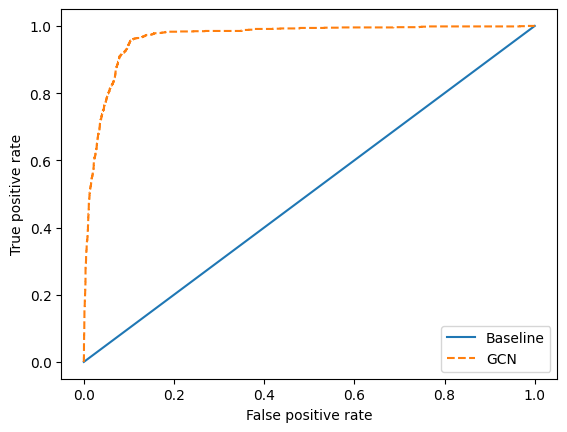

In [55]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(pred,true)

plt.figure(1)
plt.plot([0, 1], [0, 1], linestyle='-', label='Baseline')
plt.plot(fpr, tpr, linestyle='--', label='GCN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()



###Neighbor Loader:
A neighbor loader is created to sample batches of nodes from the graph for GAT and GATv2 models.


In [43]:
#GATConv does not scale by design...
#https://github.com/pyg-team/pytorch_geometric/issues/527
#Single dense graph so using NeighborLoader (where DataLoader is for multi-graph problems)
from torch_geometric.loader import NeighborLoader

batch_size = 2560
loader = NeighborLoader(
    data.cpu(),
    # Sample 170 neighbors for each node for 2 iterations
    num_neighbors=[170]*3,
    # Use a batch size for sampling training nodes
    batch_size=batch_size,
    input_nodes=data.train_mask,
)

sampled_data = next(iter(loader))
print(f'Checking that batch size is {batch_size}: {batch_size == sampled_data.batch_size}')
print(f'Percentage fraud in batch: {100*sampled_data.y.sum()/len(sampled_data.y):.4f}%')
sampled_data

Checking that batch size is 2560: True
Percentage fraud in batch: 14.4224%


Data(edge_index=[2, 5938685], num_nodes=45783, x=[45783, 32], y=[45783], num_node_features=32, num_classes=1, train_mask=[45783], test_mask=[45783], n_id=[45783], e_id=[5938685], num_sampled_nodes=[4], num_sampled_edges=[3], input_id=[2560], batch_size=2560)

##Training and Evaluation of GAT Model
A GAT model is defined as a PyTorch neural network module. It consists of two GAT layers with batch normalization.  The GAT model is trained using the defined model, loss function, and optimizer. Training metrics such as loss and AUC score are displayed.  The final GAT model is evaluated, and its accuracy is displayed. ROC curve data is computed.

In [44]:

from torch_geometric.nn import GATConv
import torch.nn as nn

class GAT(torch.nn.Module):
    def __init__(self, hidden_layers=32, heads=1, dropout_p=0.0):
        super().__init__()
        torch.manual_seed(2022)
        self.conv1 = GATConv(data.num_node_features, hidden_layers, heads, dropout=dropout_p)
        self.bn1 = nn.BatchNorm1d(hidden_layers*heads)
        self.conv2 = GATConv(hidden_layers * heads, 1, dropout=dropout_p)

    def forward(self, data, dropout_p=0.0):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.sigmoid(x)


In [45]:
lr = 0.005
epochs = 2000

model = GAT(hidden_layers = 64,heads=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=5e-4)
criterion = torch.nn.BCELoss()

losses = []
for e in range(epochs):
    epoch_loss = 0.
    for i, sampled_data in enumerate(loader):
        sampled_data.to(device)

        model.train()
        optimizer.zero_grad()
        out = model(sampled_data)
        loss = criterion(out[sampled_data.train_mask], sampled_data.y[sampled_data.train_mask].reshape(-1,1).float())
        loss.backward()
        epoch_loss += loss.item()

        optimizer.step()

        #accuracy
        ypred = model(sampled_data)
        pred = sampled_data.y[sampled_data.test_mask].clone().cpu().detach().numpy()
        true = ypred[sampled_data.test_mask].clone().cpu().detach().numpy()
        acc = roc_auc_score(pred,true)

    losses.append(epoch_loss/batch_size)

    print(f'Epoch {e} | Loss {epoch_loss:6.2f} | AUC Score = {100*acc:6.3f}% | # True Labels = {ypred.round().sum()}')


Epoch 0 | Loss   4.73 | AUC Score = 93.803% | # True Labels = 4926.0
Epoch 1 | Loss   3.23 | AUC Score = 94.534% | # True Labels = 4922.0
Epoch 2 | Loss   2.99 | AUC Score = 95.006% | # True Labels = 4936.0
Epoch 3 | Loss   2.86 | AUC Score = 94.986% | # True Labels = 5139.0
Epoch 4 | Loss   2.79 | AUC Score = 95.023% | # True Labels = 5312.0
Epoch 5 | Loss   2.69 | AUC Score = 94.834% | # True Labels = 5488.0
Epoch 6 | Loss   2.65 | AUC Score = 95.324% | # True Labels = 5623.0
Epoch 7 | Loss   2.58 | AUC Score = 95.125% | # True Labels = 5751.0
Epoch 8 | Loss   2.52 | AUC Score = 95.393% | # True Labels = 5747.0
Epoch 9 | Loss   2.47 | AUC Score = 95.506% | # True Labels = 5895.0
Epoch 10 | Loss   2.42 | AUC Score = 95.739% | # True Labels = 5904.0
Epoch 11 | Loss   2.39 | AUC Score = 95.575% | # True Labels = 5820.0
Epoch 12 | Loss   2.35 | AUC Score = 95.811% | # True Labels = 5975.0
Epoch 13 | Loss   2.32 | AUC Score = 95.570% | # True Labels = 5954.0
Epoch 14 | Loss   2.30 | AUC S

In [46]:
data.to(device)
ypred = model(data)
pred = data.y[data.test_mask].clone().cpu().detach().numpy()
true = ypred[data.test_mask].clone().cpu().detach().numpy()
acc = roc_auc_score(pred,true)
print(f"Final model accuracy for GAT is : {100*acc:.4f}%")

Final model accuracy for GAT is : 97.7017%


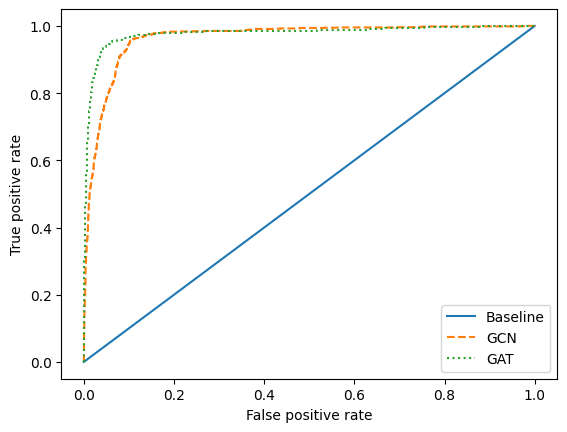

In [54]:

# fpr2, tpr2, _ = roc_curve(pred,true)

plt.figure(1)
plt.plot([0, 1], [0, 1], linestyle='-', label='Baseline')
plt.plot(fpr, tpr, linestyle='--', label='GCN')
plt.plot(fpr2, tpr2, linestyle=':', label='GAT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()



In [ ]:
# Additional parameters to change:
#  - number of epochs
#  - number of hidden layers
#  - number of heads
#  - dropout probability
#  - learning rate (optimizer)
#  - weight decay rate (optimizer)


##Training and Evaluation of GATv2 Model
A GATv2 model is defined as a PyTorch neural network module. It consists of two GATv2 layers with batch normalization. The GATv2 model is trained using the defined model, loss function, and optimizer. Training metrics such as loss and AUC score are displayed.  The final GATv2 model is evaluated, and its accuracy is displayed. ROC curve data is computed and plotted alongside other models.


GATv2Conv —> https://arxiv.org/pdf/2105.14491.pdf

In [48]:
from torch_geometric.nn import GATv2Conv

class GATv2(torch.nn.Module):
    def __init__(self, hidden_layers=32, heads=1, dropout_p=0.0):
        super().__init__()
        torch.manual_seed(2022)
        self.conv1 = GATv2Conv(data.num_node_features, hidden_layers, heads, dropout=dropout_p)
        self.bn1 = nn.BatchNorm1d(hidden_layers*heads)
        self.conv2 = GATv2Conv(hidden_layers * heads, 1, dropout=dropout_p)

    def forward(self, data, dropout_p=0.0):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.sigmoid(x)


In [49]:
lr = 0.005
epochs = 2000

model = GATv2(hidden_layers = 64,heads=1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=5e-4)


criterion = torch.nn.BCELoss()

losses = []
for e in range(epochs):
    epoch_loss = 0.
    for i, sampled_data in enumerate(loader):
        sampled_data.to(device)

        model.train()
        optimizer.zero_grad()
        out = model(sampled_data)
        loss = criterion(out[sampled_data.train_mask], sampled_data.y[sampled_data.train_mask].reshape(-1,1).float())
        loss.backward()
        epoch_loss += loss.item()

        optimizer.step()

        #accuracy
        ypred = model(sampled_data)
        pred = sampled_data.y[sampled_data.test_mask].clone().cpu().detach().numpy()
        true = ypred[sampled_data.test_mask].clone().cpu().detach().numpy()
        acc = roc_auc_score(pred,true)

    losses.append(epoch_loss/batch_size)

    print(f'Epoch {e} | Loss {loss:6.2f} | AUC Score = {100*acc:6.3f}% | # True Labels = {ypred.round().sum()}')


Epoch 0 | Loss   0.31 | AUC Score = 90.891% | # True Labels = 2849.0
Epoch 1 | Loss   0.23 | AUC Score = 93.351% | # True Labels = 4840.0
Epoch 2 | Loss   0.21 | AUC Score = 94.375% | # True Labels = 5295.0
Epoch 3 | Loss   0.19 | AUC Score = 94.908% | # True Labels = 5478.0
Epoch 4 | Loss   0.19 | AUC Score = 95.275% | # True Labels = 5731.0
Epoch 5 | Loss   0.18 | AUC Score = 95.194% | # True Labels = 5722.0
Epoch 6 | Loss   0.17 | AUC Score = 95.386% | # True Labels = 6028.0
Epoch 7 | Loss   0.16 | AUC Score = 95.869% | # True Labels = 6138.0
Epoch 8 | Loss   0.16 | AUC Score = 95.751% | # True Labels = 6255.0
Epoch 9 | Loss   0.16 | AUC Score = 95.959% | # True Labels = 6156.0
Epoch 10 | Loss   0.15 | AUC Score = 95.960% | # True Labels = 6349.0
Epoch 11 | Loss   0.15 | AUC Score = 95.811% | # True Labels = 6365.0
Epoch 12 | Loss   0.15 | AUC Score = 96.014% | # True Labels = 6225.0
Epoch 13 | Loss   0.15 | AUC Score = 96.456% | # True Labels = 6102.0
Epoch 14 | Loss   0.15 | AUC S

In [50]:
data.to(device)
ypred = model(data)
pred = data.y[data.test_mask].clone().cpu().detach().numpy()
true = ypred[data.test_mask].clone().cpu().detach().numpy()
acc = roc_auc_score(pred,true)
print(f"Final model accuracy for GATv2 is : {100*acc:.4f}%")

Final model accuracy for GATv2 is : 98.3556%


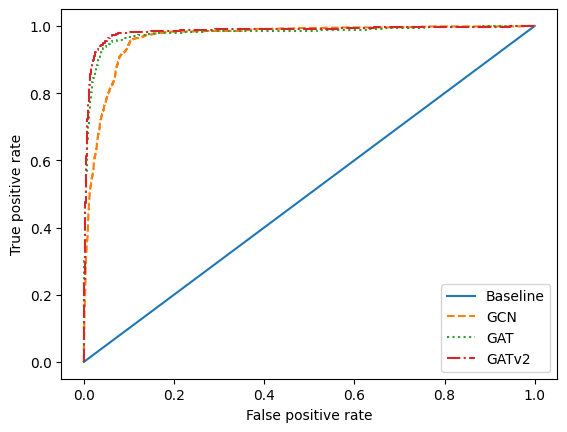

In [52]:
fpr3, tpr3, _ = roc_curve(pred,true)

plt.figure(1)
plt.plot([0, 1], [0, 1], linestyle='-', label='Baseline')
plt.plot(fpr, tpr, linestyle='--', label='GCN')
plt.plot(fpr2, tpr2, linestyle=':', label='GAT')
plt.plot(fpr3, tpr3, linestyle='-.', label='GATv2')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()
